Esketit
---

In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

In [7]:
pre_path = 'data/'
suffix = '_w_lix_sentiment.csv'

subreddits = list(glob.glob('data/*'))
subreddits = list(set([sub.split('\\')[1].split('_')[0] for sub in subreddits]))
items_to_remove = ['combined']
subreddits = [sub for sub in subreddits if sub not in items_to_remove]
# print(subreddits)

n_subs =  len(subreddits)

In [9]:
dfs = {}
for sub in subreddits:
    dfs[sub] = pd.read_csv(pre_path + sub + suffix, index_col = 'comment_id')

Spørgsmål:  
Hvorfor log-transformerer vi upvotes?  
Bør vi log-transformere lix?  
Hvorfor vælger vi standardisering frem for normalisering?  
Hvorfor vælger vi at evaluere på Silhuette Score i stedet for Davies Bouldin Score eller Calinski-Harabasz Score? Og for GMM hvorfor evaluerer vi ikke bare log-likelihood?  

First off, let's inspect the data transformations
---
Hypothesis: We want to log transform likes.
Then we want to either standardize or normalize all 3 parameters, so they are equally distant. Unless of course we want some parameter to have a higher weight?
For the standardize/normalize we should do the 3 scatterplots, 3 for normal and 3 for standard

### Log-transforming likes (Should be shown in report but not relevant in optimization)

In [84]:
# dt['log_upvotes'] = dt['upvotes'].apply(lambda x: np.log(x))

# fig, axs = plt.subplots(ncols = 2, figsize=(10, 5))

# sns.histplot(ax = axs[0], data=dt, x="upvotes", log_scale = False)
# sns.histplot(ax = axs[1], data=dt, x="upvotes", log_scale = True)

# fig.suptitle(f'Upvotes vs. log-transformed upvotes in r/{sub_chosen}', fontsize=16)
# fig.tight_layout()
# plt.show()

Find the optimal model
---

In [10]:
# It goes something like this:
attribute_cols = ['sentiment_score', 'lix_score','log_upvotes']

gmm_sil = {}
hierarchical_sil = {}
kmeans_sil = {}

gmm_cal = {}
hierarchical_cal = {}
kmeans_cal = {}
gmm_score = {}

n_clusters_range = range(2, 20)


for sub, df in dfs.items():
    df = df[attribute_cols]

    gmm_sil[sub] = []
    hierarchical_sil[sub] = []
    kmeans_sil[sub] = []

    gmm_cal[sub] = []
    hierarchical_cal[sub] = []
    kmeans_cal[sub] = []

    gmm_score[sub] = []


    points = StandardScaler().fit_transform(df)
    # points = minmax_scale(df, axis = 0)

    for n_clusters in n_clusters_range:

        hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
        kmeans = KMeans(n_clusters=n_clusters, random_state = 42)
        GMM = GaussianMixture(n_components=n_clusters, random_state = 42)

        hierarchical.fit(points)
        kmeans.fit(points)
        GMM.fit(points)


        hierarchical_sil[sub].append(silhouette_score(points, hierarchical.labels_))
        hierarchical_cal[sub].append(calinski_harabasz_score(points, hierarchical.labels_))

        kmeans_sil[sub].append(silhouette_score(points, kmeans.labels_))
        kmeans_cal[sub].append(calinski_harabasz_score(points, kmeans.labels_))

        gmm_sil[sub].append(silhouette_score(points, GMM.predict(points)))
        gmm_cal[sub].append(calinski_harabasz_score(points, GMM.predict(points)))

        gmm_score[sub].append(GMM.score(points))

# How do i then choose which one is better? Should the "optimal amount of clusters" vary based on the clustering method?
# That would seem very illogical, so i guess not. Then we plot the average score for each amount of clusters


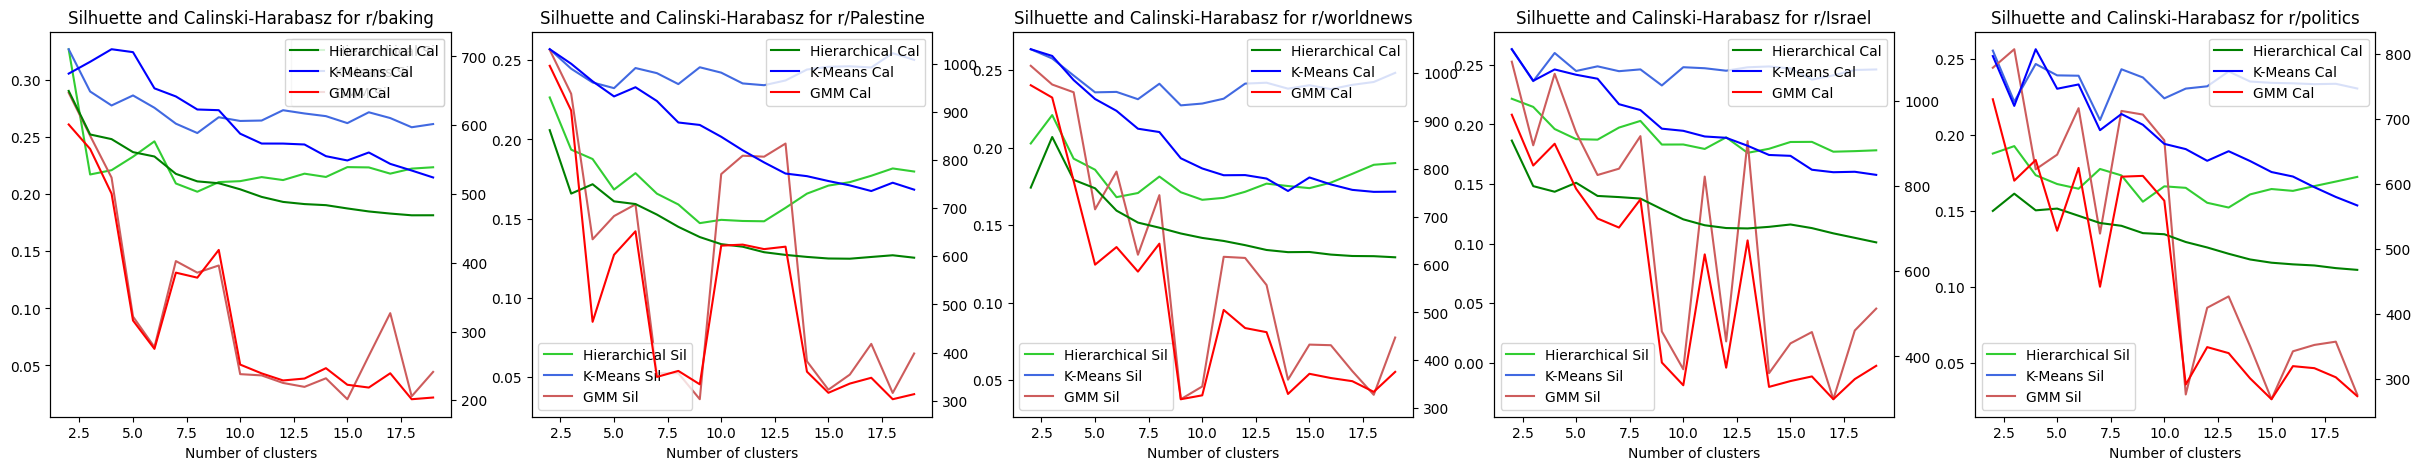

In [12]:
fig, axes = plt.subplots(nrows = 1 ,ncols = n_subs, figsize=(30, 5))
x_list = n_clusters_range

for i, sub in enumerate(subreddits):
    axes[i].set_title(f'Silhuette and Calinski-Harabasz for r/{sub}', fontsize=12)
    # axes[i].set_title(f'Silhuette score for r/{sub}', fontsize=16)
    axes[i].plot(x_list, hierarchical_sil[sub], label = 'Hierarchical Sil', color = 'limegreen')
    axes[i].plot(x_list, kmeans_sil[sub], label = 'K-Means Sil', color = 'royalblue')
    axes[i].plot(x_list, gmm_sil[sub], label = 'GMM Sil', color = 'indianred')
    cal_ax = axes[i].twinx()
    cal_ax.plot(x_list, hierarchical_cal[sub], label = 'Hierarchical Cal', color = 'green')
    cal_ax.plot(x_list, kmeans_cal[sub], label = 'K-Means Cal', color = 'blue')
    cal_ax.plot(x_list, gmm_cal[sub], label = 'GMM Cal', color = 'red')
    cal_ax.legend()
    axes[i].legend()
    axes[i].set_xlabel('Number of clusters')


plt.show()

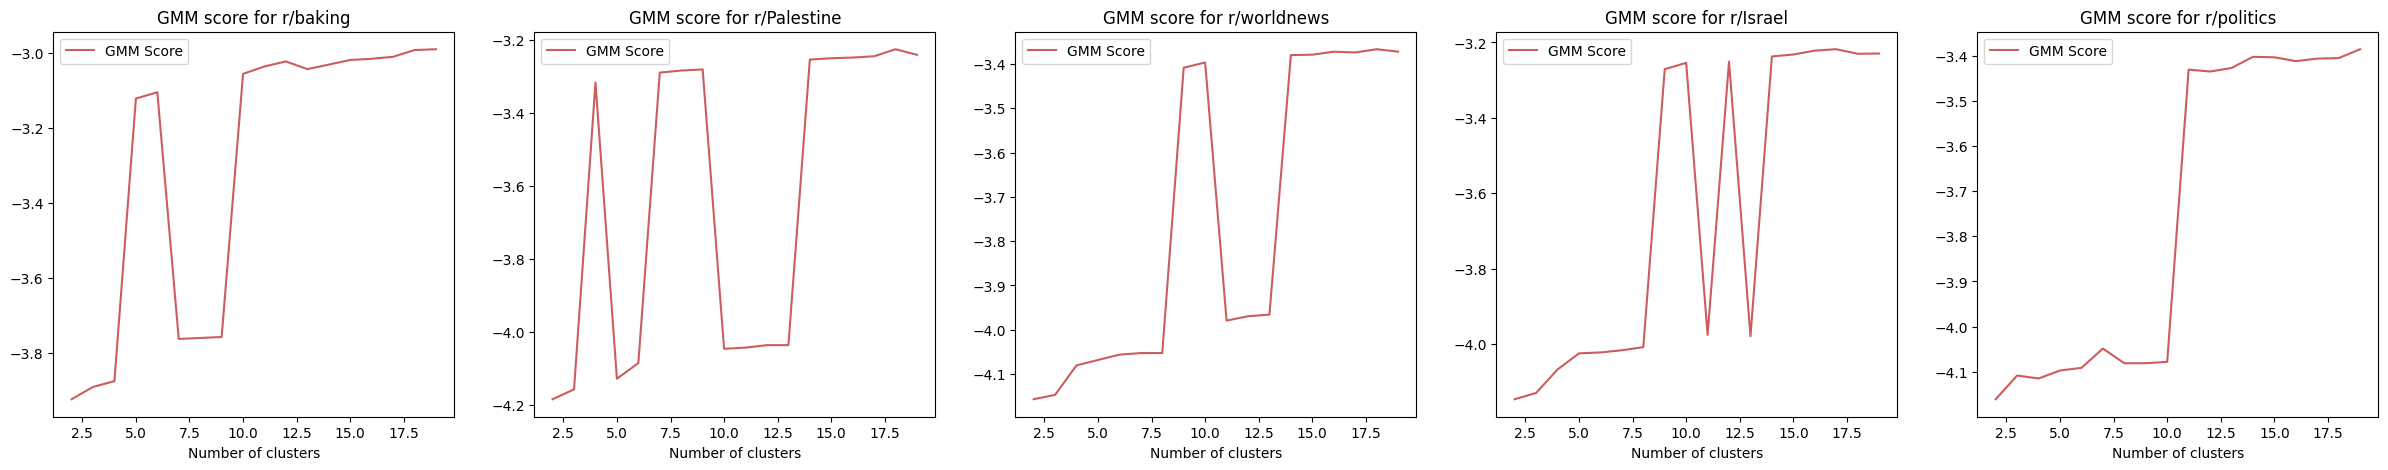

In [14]:
fig, axes = plt.subplots(nrows = 1 ,ncols = n_subs, figsize=(30, 5))
x_list = n_clusters_range

for i, sub in enumerate(subreddits):
    axes[i].set_title(f'GMM score for r/{sub}', fontsize=12)
    # axes[i].set_title(f'Silhuette score for r/{sub}', fontsize=16)
    # axes[i].plot(x_list, hierarchical_sil[sub], label = 'Hierarchical Sil', color = 'limegreen')
    # axes[i].plot(x_list, kmeans_sil[sub], label = 'K-Means Sil', color = 'royalblue')
    axes[i].plot(x_list, gmm_score[sub], label = 'GMM Score', color = 'indianred')
    # cal_ax = axes[i].twinx()
    # cal_ax.plot(x_list, hierarchical_cal[sub], label = 'Hierarchical Cal', color = 'green')
    # cal_ax.plot(x_list, kmeans_cal[sub], label = 'K-Means Cal', color = 'blue')
    # cal_ax.plot(x_list, gmm_cal[sub], label = 'GMM Cal', color = 'red')
    # cal_ax.legend()
    axes[i].legend()
    axes[i].set_xlabel('Number of clusters')


plt.show()

In [ ]:
#GMM model outperforms both k-means and hierarchical clustering on both silhuette score and calinski-harabasz index.
#We primarily use the silhuette score to evaluate the clustering models, as it is a more robust metric than the calinski-harabasz index.

DBSCAN does not even come close - see for yourself on below graph
---

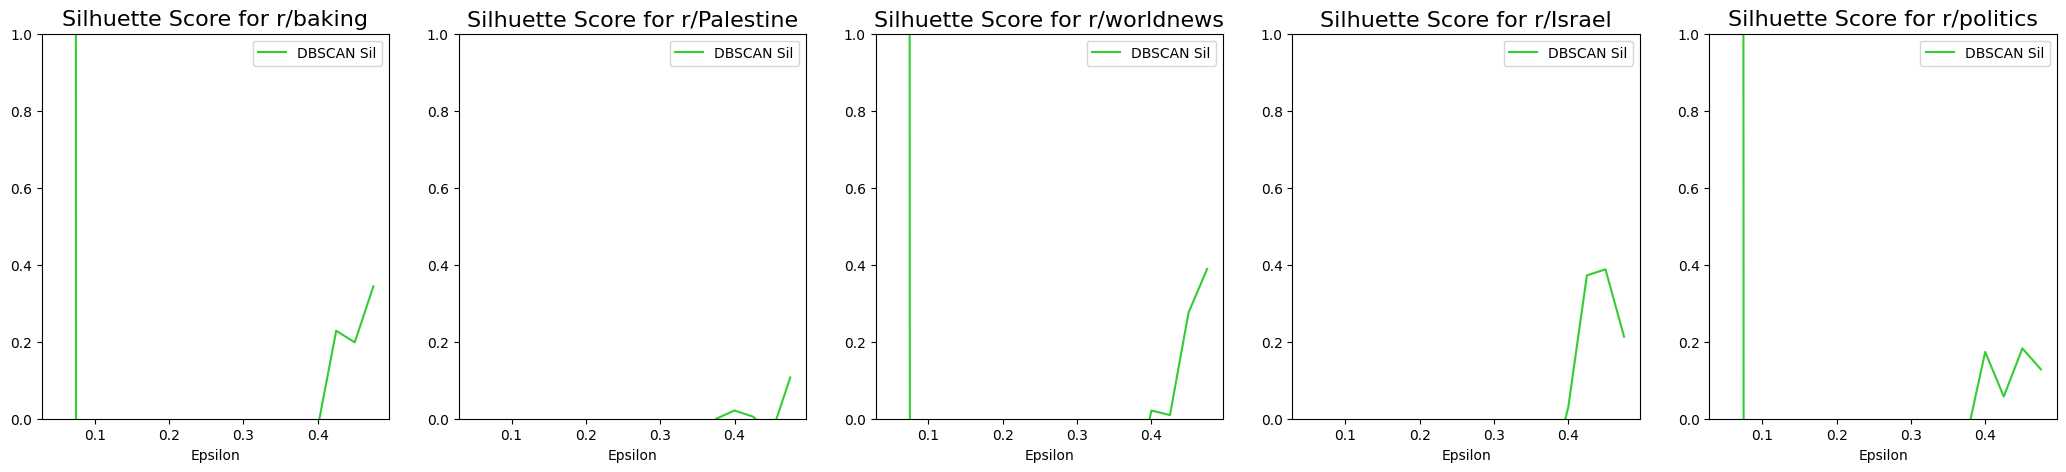

In [11]:
# Let's do the same shit but with DBSCAN
attribute_cols = ['sentiment_score', 'lix_score','log_upvotes']

DBSCAN_sil = {}

epsilons = np.arange(0.05, 0.50, 0.025)


for sub, df in dfs.items():
    df = df[attribute_cols]
    DBSCAN_sil[sub] = []
    points = StandardScaler().fit_transform(df)
    for ep in epsilons:
        dbscan = DBSCAN(eps=ep) #eps is max distance between points for the same cluster
        dbscan.fit(points)
        
        #davies_bouldin_score not defined for single cluster
        if len(np.unique(dbscan.labels_)) == 1:
            DBSCAN_sil[sub].append(99)
        else:
            DBSCAN_sil[sub].append(silhouette_score(points, dbscan.labels_))

fig, axes = plt.subplots(nrows = 1 ,ncols = n_subs, figsize=(26, 5))
x_list = epsilons

for i, sub in enumerate(subreddits):
    axes[i].set_title(f'Silhuette Score for r/{sub}', fontsize=16)
    axes[i].plot(x_list, DBSCAN_sil[sub], label = 'DBSCAN Sil', color = 'limegreen')
    axes[i].legend()
    axes[i].set_xlabel('Epsilon')
    axes[i].set_ylim(0, 1)


plt.show()

Run the optimized models here
---

In [ ]:
# #define columns for clustering
attribute_cols = ['sentiment_score', 'lix_score','log_upvotes']

optimal_clusters = {}

optimal_clusters['GMM'] = {
    'Israel' : 10,
    'Palestine' : 9,
    'politics' : 11,
    'worldnews' : 9,
    'baking': 6
}

optimal_clusters['others'] = {
    'Israel' : 4,
    'Palestine' : 4,
    'politics' : 4,
    'worldnews' : 4,
    'baking': 4
}

optimal_epsilons = {
    'Israel' : 0.45,
    'Palestine' : 0.50,
    'politics' : 0.40,
    'worldnews' : 0.50,
    'baking': 0.50
}

for sub, df in dfs.items():
    df_cluster = df[attribute_cols].copy()
    
    # #Standardize the data
    df_cluster_scaled = StandardScaler().fit_transform(df_cluster)

    # #Apply clustering using tuned hyperparameters
    gmm_n_clusters = optimal_clusters['GMM'][sub]
    n_clusters = optimal_clusters['others'][sub]
    ep = optimal_epsilons[sub]

    GMM = GaussianMixture(n_components=gmm_n_clusters)
    GMM.fit(df_cluster_scaled)

    dbscan = DBSCAN(eps=ep) #eps is max distance between points for the same cluster
    dbscan.fit(df_cluster_scaled)

    kmeans = KMeans(n_clusters=n_clusters, random_state = 42)
    kmeans.fit(df_cluster_scaled)


    # #### Add the cluster labels to the dataframe
    # df['hierarchical_cluster'] = hierarchical.labels_
    # df['kmeans_cluster'] = kmeans.labels_
    # df['dbscan_cluster'] = dbscan.labels_

    #Assign the cluster labels
    df['DBSCAN_cluster'] = dbscan.labels_
    df['GMM_cluster'] = GMM.predict(df_cluster_scaled)
    df['kmeans_cluster'] = kmeans.labels_


    # #### Export the new dataframes
    df.to_csv(f'data/{sub}_clustered.csv')


Load the data and analyze it
---

In [21]:
pre_path = 'data/'
suffix = '_clustered.csv'

subreddits = list(glob.glob('data/*'))
subreddits = list(set([sub.split('\\')[1].split('_')[0] for sub in subreddits]))
items_to_remove = ['combined']
subreddits = [sub for sub in subreddits if sub not in items_to_remove]

n_subs =  len(subreddits)

dfs_clustered = {}
for sub in subreddits:
    dfs_clustered[sub] = pd.read_csv(pre_path + sub + suffix, index_col = 'comment_id')

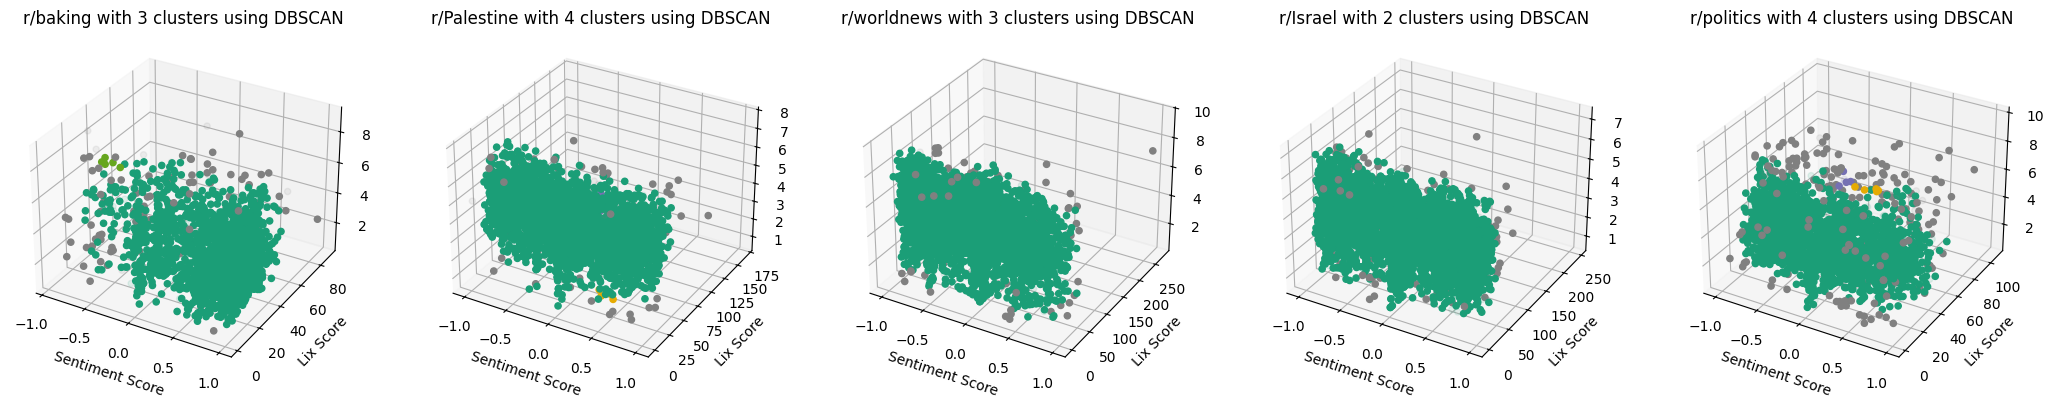

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=n_subs, figsize=(26, 5), subplot_kw={'projection': '3d'})

method = 'DBSCAN'
cluster_type = f'{method}_cluster'

for i, (sub, df) in enumerate(dfs_clustered.items()):
    n_clusters = df[cluster_type].nunique()

    # Set color: grey for cluster -1, others will use a colormap
    colors = df[cluster_type].apply(lambda x: 'grey' if x == -1 else None)
    
    # Assign transparency: 50% for cluster -1, 100% (1.0) for others
    alphas = df[cluster_type].apply(lambda x: 0.1 if x == -1 else 1.0)

    # Handle valid colors for other clusters
    # Replace 'None' with colormap values for non -1 clusters
    cmap = plt.get_cmap('Dark2', n_clusters)
    cluster_colors = df[cluster_type].apply(lambda x: cmap(x) if x != -1 else 'grey')

    # Plot the 3D scatterplot
    scatter = axes[i].scatter(
        df['sentiment_score'], df['lix_score'], df['log_upvotes'],
        facecolors=cluster_colors, alpha=alphas
    )
    axes[i].set_title(f'r/{sub} with {n_clusters} clusters using {method}')
    axes[i].set_xlabel('Sentiment Score')
    axes[i].set_ylabel('Lix Score')

plt.show()


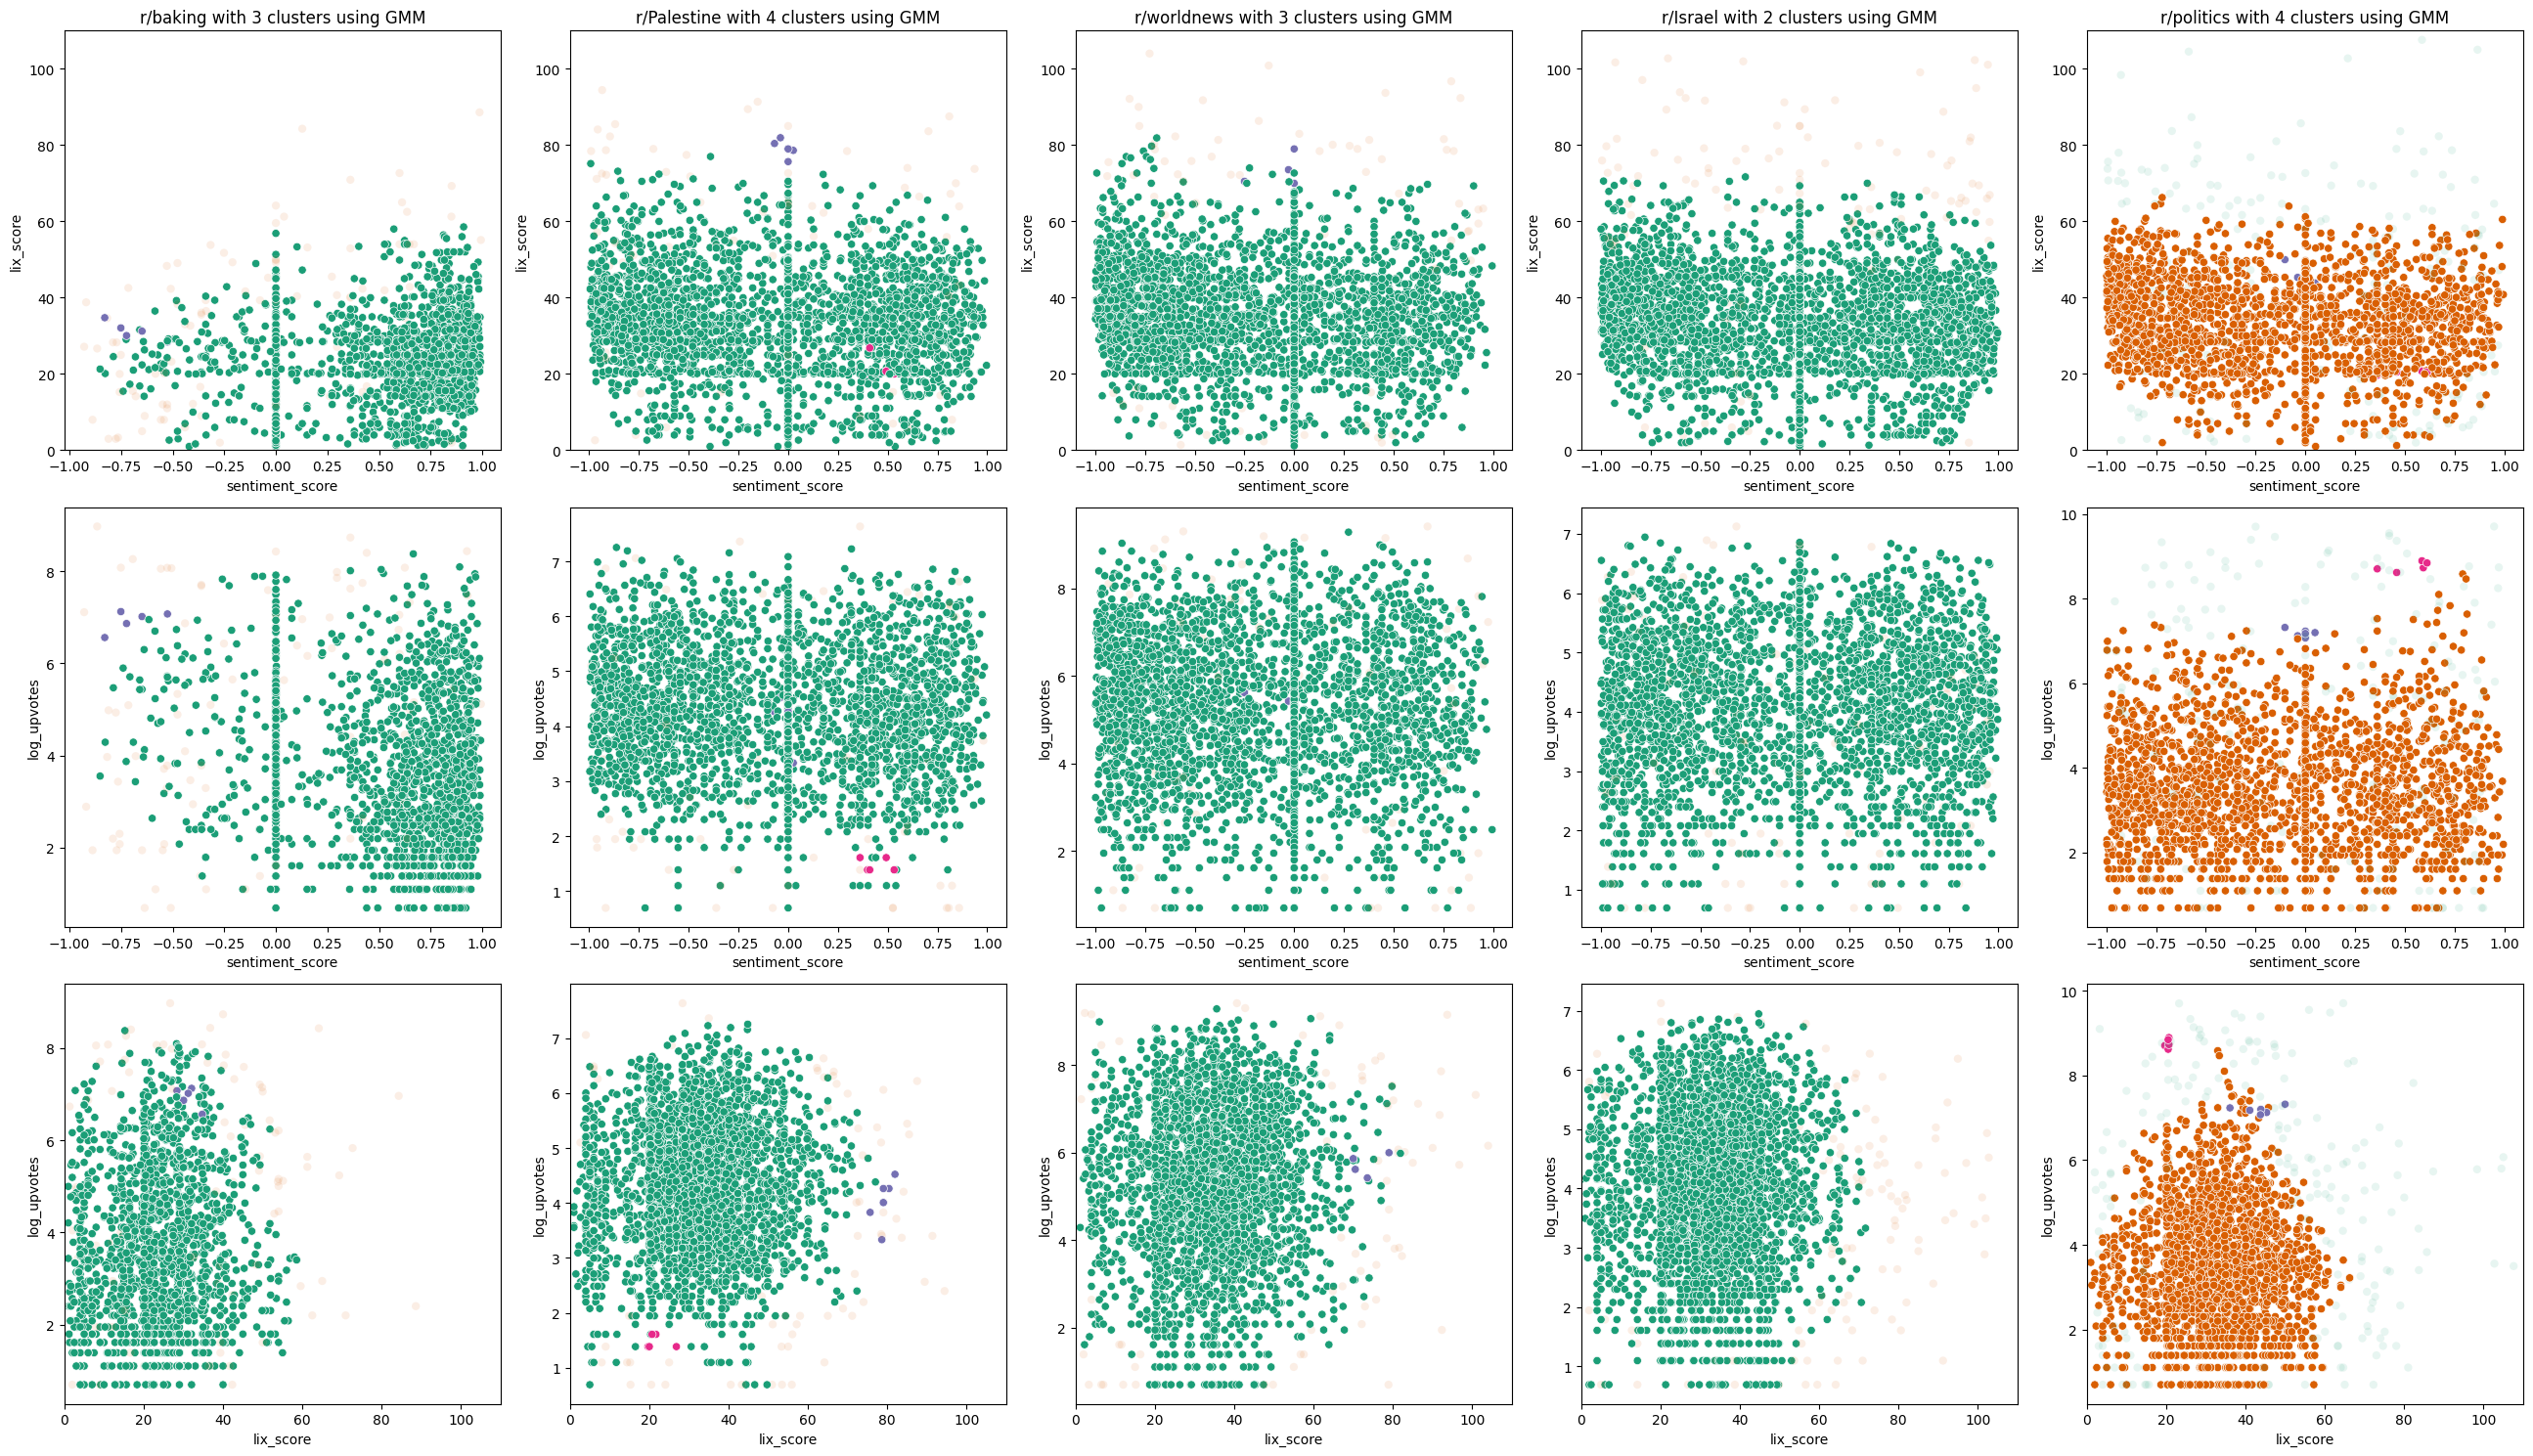

In [28]:
fig, axes = plt.subplots(nrows=3, ncols=n_subs, figsize=(26, 15))

lix_lim = [0, 110]

method = 'DBSCAN'
cluster_type = f'{method}_cluster'

for i, (sub, df) in enumerate(dfs_clustered.items()):
    n_clusters = df[cluster_type].nunique()

    # Set color: grey for cluster -1, others will use a colormap
    colors = df[cluster_type].apply(lambda x: 'grey' if x == -1 else None)
    alphas = df[cluster_type].apply(lambda x: 0.1 if x == -1 else 1.0)
    
    # Handle valid colors for other clusters
    cmap = plt.get_cmap('Dark2', n_clusters)
    cluster_colors = df[cluster_type].apply(lambda x: cmap(x) if x != -1 else 'grey')

    # Plot the 2D scatterplots
    sns.scatterplot(ax=axes[0, i], data=df, x="sentiment_score", y="lix_score", hue=cluster_colors, palette='Dark2', legend=False, alpha = alphas)
    sns.scatterplot(ax=axes[1, i], data=df, x="sentiment_score", y="log_upvotes", hue=cluster_colors, palette='Dark2', legend=False, alpha = alphas)
    sns.scatterplot(ax=axes[2, i], data=df, x="lix_score", y="log_upvotes", hue=cluster_colors, palette='Dark2', legend=False, alpha = alphas)

    axes[0, i].set_ylim(lix_lim)
    axes[2, i].set_xlim(lix_lim)

    axes[0, i].set_title(f'r/{sub} with {n_clusters} clusters using GMM')

plt.tight_layout()
plt.show()

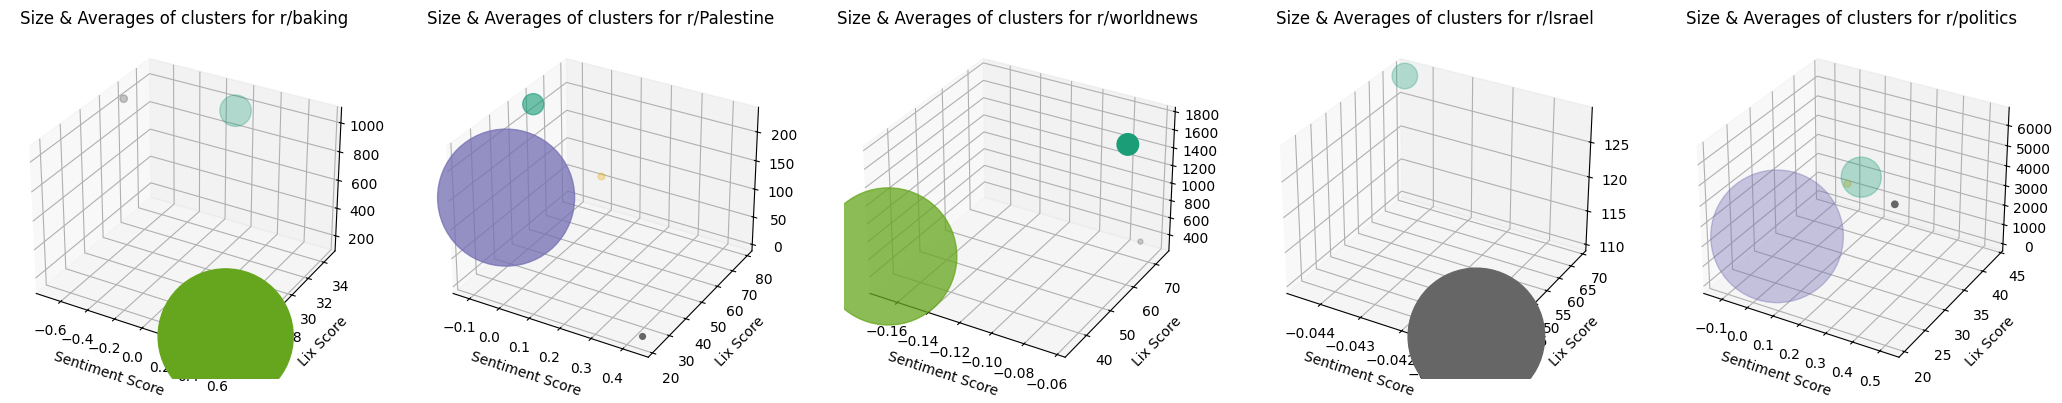

In [29]:
cluster_stats = {}

method = 'DBSCAN' #Can also be 'DBSCAN'
cluster_type = f'{method}_cluster'

for sub, df in dfs_clustered.items():
    cluster_stats[sub] = pd.DataFrame(columns=['sub', 'cluster', 'observations', 'percentage', 'avg_upvotes', 'avg_lix_score', 'avg_sentiment_score', 'upvotes_std', 'lix_score_std', 'sentiment_score_std']) #
    total_observations = len(df)
    for cluster in df[cluster_type].unique():
        cluster_df = df[df[cluster_type] == cluster]
        cluster_observations = len(cluster_df)
        percentage = cluster_observations / total_observations
        avg_upvotes = cluster_df['upvotes'].mean()
        avg_lix_score = cluster_df['lix_score'].mean()
        avg_sentiment_score = cluster_df['sentiment_score'].mean()
        opvotes_std = cluster_df['upvotes'].std()
        lix_score_std = cluster_df['lix_score'].std()
        sentiment_score_std = cluster_df['sentiment_score'].std()
        
        cluster_stats[sub].loc[cluster] = {
            'sub': sub,
            'cluster': cluster,
            'observations': cluster_observations,
            'percentage': percentage,
            'avg_upvotes': avg_upvotes,
            'avg_lix_score': avg_lix_score,
            'avg_sentiment_score': avg_sentiment_score,
            'upvotes_std': opvotes_std,
            'lix_score_std': lix_score_std,
            'sentiment_score_std': sentiment_score_std
        }

fig, axes = plt.subplots(nrows = 1, ncols = n_subs, figsize=(26, 5), subplot_kw={'projection':'3d'})

for i, (sub, df) in enumerate(cluster_stats.items()):
    n_clusters = df.shape[0]
    # #Plot the 3d scatterplot
    axes[i].scatter(df['avg_sentiment_score'], df['avg_lix_score'], df['avg_upvotes'], facecolors='none', c = df['cluster'], cmap = 'Dark2', s = df['percentage']*100*100)
    axes[i].set_title(f'Size & Averages of clusters for r/{sub}')
    axes[i].set_xlabel('Sentiment Score')
    axes[i].set_ylabel('Lix Score')

In [ ]:
cluster_stats['baking']
points_attributes = ['percentage', 'avg_upvotes', 'avg_lix_score', 'avg_sentiment_score', 'upvotes_std', 'lix_score_std', 'sentiment_score_std']

all_clusters = pd.concat(cluster_stats.values())

all_clusters['sil'] = silhouette_score(all_clusters[points_attributes], all_clusters['sub'])
all_clusters

sub  cluster  observations  percentage  avg_upvotes  avg_lix_score  \
5      baking        5           288    0.163916   392.006944      22.917217   
3      baking        3           279    0.158793   622.526882      34.042212   
4      baking        4           251    0.142857    37.525896      22.797692   
2      baking        2           142    0.080820   148.401408       4.750704   
1      baking        1           399    0.227092    10.368421      20.837636   
0      baking        0           398    0.226522    65.082915      30.127614   
6    politics        6           114    0.048264  2016.307018      32.558470   
8    politics        8           103    0.043607  2301.097087      32.737241   
0    politics        0           205    0.086791   116.536585      16.331347   
10   politics       10           425    0.179932    46.555294      34.017875   
4    politics        4           328    0.138865    69.240854      35.401896   
2    politics        2           263    0.111346   121.923954      38.501727   
7    politics        7            66    0.027942   262.651515      71.175782   
5    politics        5           325    0.137595    18.387692      27.251196   
1    politics        1           182    0.077053    21.197802      49.432136   
9    politics        9           123    0.052075     9.162602      14.482811   
3    politics        3           228    0.096528     6.868421      36.354946   
5   Palestine        5           507    0.171806   115.895464      28.505355   
6   Palestine        6           169    0.057269   236.627219      53.500193   
2   Palestine        2            51    0.017282    78.215686      14.550191   
3   Palestine        3           226    0.076584   329.915929      28.986659   
7   Palestine        7           552    0.187055   177.315217      29.096933   
8   Palestine        8           620    0.210098   112.003226      32.276023   
0   Palestine        0           473    0.160285    81.636364      35.607540   
1   Palestine        1           255    0.086411    33.286275      37.690518   
4   Palestine        4            98    0.033209    27.765306      52.796457   
2   worldnews        2           419    0.139900  2020.668258      34.591126   
1   worldnews        1           468    0.156260   396.651709      35.210049   
6   worldnews        6           224    0.074791   504.232143      12.361948   
7   worldnews        7           421    0.140568   557.641330      27.629904   
8   worldnews        8           526    0.175626   167.300380      35.514505   
3   worldnews        3           368    0.122871   980.135870      46.239275   
4   worldnews        4            79    0.026377   651.974684      77.267629   
0   worldnews        0           292    0.097496    46.397260      40.268683   
5   worldnews        5           198    0.066110     8.631313      30.281405   
2      Israel        2           361    0.110974   246.808864      35.262587   
1      Israel        1           335    0.102982   102.537313      18.933747   
6      Israel        6           397    0.122041    49.904282      37.426465   
8      Israel        8            69    0.021211    61.942029      84.160230   
0      Israel        0           278    0.085460   371.251799      31.184223   
9      Israel        9           594    0.182601    92.279461      28.869607   
5      Israel        5           554    0.170304    84.684116      42.333804   
4      Israel        4           203    0.062404    10.600985      37.299195   
7      Israel        7           336    0.103289    16.074405      25.074753   
3      Israel        3           126    0.038733     7.841270      41.821532   

    avg_sentiment_score  upvotes_std  lix_score_std  sentiment_score_std  \
5              0.717481   640.339517       7.170227             0.115167   
3             -0.009200   994.012936      13.798948             0.429379   
4              0.041149    45.842800       6.533742             0.261356   
2              0.201370  